In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from netCDF4 import Dataset 

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy


f_pr_thresh = xr.open_dataset('/g/data/nf33/cb4968/metrics/models/ICON/precip/pr_percentiles/icon_d3hp003/pr_percentiles_icon_d3hp003_3hrly_0-360_-30-30_3600x1800_2020-03_2021-02.nc')
threshold = np.mean(f_pr_thresh['pr_percentiles_95'])
print('threshold',threshold)
f_pr_thresh.close()


f_iorg = xr.open_dataset('/g/data/nf33/cb4968/metrics/models/ICON/doc_metrics/i_org/icon_d3hp003/i_org_icon_d3hp003_3hrly_100-149_-13-13_3600x1800_2020-03_2021-02.nc')
i_org_95 = f_iorg['i_org_thres_pr_percentiles_95']
f_iorg.close()

file_pr = '/g/data/w28/ym7079/Hackthon/DOC/hk25-AusNode-DOCmeso/get_metrics/Yinglin/icon_pr_2020-03-02.nc'
f_pr = xr.open_dataset(file_pr)
pr_95 = f_pr['pr']
f_pr.close()

threshold <xarray.DataArray 'pr_percentiles_95' ()> Size: 8B
array(0.55038012)
Coordinates:
    quantile  float64 8B ...


In [2]:
loc = i_org_95.where(i_org_95 == i_org_95.min(), drop=True)
print(loc)
coords = {dim: loc[dim].values[0] for dim in loc.dims}

<xarray.DataArray 'i_org_thres_pr_percentiles_95' (time: 1)> Size: 8B
array([0.80259729])
Coordinates:
  * time     (time) datetime64[ns] 8B 2020-05-05T15:00:00


In [3]:
loc = i_org_95.where(i_org_95 == i_org_95.max(), drop=True)
print(loc)
coords = {dim: loc[dim].values[0] for dim in loc.dims}

<xarray.DataArray 'i_org_thres_pr_percentiles_95' (time: 1)> Size: 8B
array([0.90476164])
Coordinates:
  * time     (time) datetime64[ns] 8B 2020-03-02T09:00:00


threshold <xarray.DataArray 'pr_percentiles_95' ()> Size: 8B
array(0.55038012)
Coordinates:
    quantile  float64 8B ...
0.9016537741126273


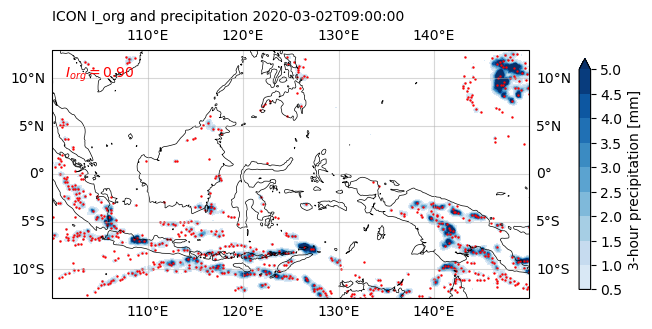

In [4]:

''' 
# -----------------
#     I_org
# -----------------
paper: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016ms000802

'''

# == imports ==
# -- packages --
import numpy as np
import xarray as xr
from scipy.ndimage import convolve
from scipy.ndimage import maximum_filter


# == smoothing function --
def exponential_kernel(size, decay_distance):
    ''' Creates grid to smooth over, and the magnitude of decay '''
    x, y = np.meshgrid(np.arange(size), np.arange(size))        # matrix to smooth over
    dist = np.sqrt((x - size//2)**2 + (y - size//2)**2)         # distance to smooth over
    kernel = np.exp(-dist / decay_distance)                     # rate of decay
    kernel /= kernel.sum()                                      # smoothing
    return kernel

def apply_smoothing(da_orig, kernel_size, decay_distance):
    kernel = exponential_kernel(size = kernel_size, decay_distance = decay_distance)
    da = convolve(da_orig, kernel, mode='nearest')                   # returns numpy, so put in xarray again later
    da = xr.DataArray(                                          
        data = da,
        dims=["lat", "lon"],
        coords={"lat": da_orig.lat, "lon": da_orig.lon},
        )
    return da

def find_conv_cores(da, threshold, exceed_threshold = True):
    # -- find local maxima --
    local_max = maximum_filter(da, size=3)
    local_maxima = (da == local_max) * 1

    # -- only consider points above threshold --
    if exceed_threshold:
        local_maxima = (local_maxima * da) > threshold

    # -- find associated lat, lon --
    latitudes, longitudes = np.where(local_maxima)
    lat_values = local_maxima.lat.values[latitudes]
    lon_values = local_maxima.lon.values[longitudes]
    return da, lat_values, lon_values


def get_area_matrix(lat, lon):
    ''' # area of domain: cos(lat) * (dlon * dlat) R^2 (area of gridbox decrease towards the pole as gridlines converge) '''
    lonm, latm = np.meshgrid(lon, lat)
    dlat = lat.diff(dim='lat').data[0]
    dlon = lon.diff(dim='lon').data[0]
    R = 6371     # km
    area =  np.cos(np.deg2rad(latm))*np.float64(dlon * dlat * R**2*(np.pi/180)**2) 
    da_area = xr.DataArray(data = area, dims = ["lat", "lon"], coords = {"lat": lat, "lon": lon}, name = "area")
    return da_area

# == helper funcs ==
def haversine_dist(lat1, lon1, lat2, lon2):
    '''Great circle distance (from Haversine formula)
    input: 
    lon range: [-180, 180]
    lat range: [-90, 90]
    (Takes vectorized input) 

    Formula:
    h = sin^2(phi_1 - phi_2) + (cos(phi_1)cos(phi_2))sin^2(lambda_1 - lambda_2)
    (1) h = sin(theta/2)^2
    (2) theta = d_{great circle} / R    (central angle, theta)
    (1) in (2) and rearrange for d gives
    d = R * sin^-1(sqrt(h))*2 
    where 
    phi -latitutde
    lambda - longitude
    '''
    R = 6371                                                                                    # radius of earth in km
    lat1 = np.deg2rad(lat1)                                                                     # function requires degrees in radians 
    lon1 = np.deg2rad(lon1-180)                                                                 # and lon in range [-180, 180]
    lat2 = np.deg2rad(lat2)                                                                     #
    lon2 = np.deg2rad(lon2-180)                                                                 #
    h = np.sin((lat2 - lat1)/2)**2 + np.cos(lat1)*np.cos(lat2) * np.sin((lon2 - lon1)/2)**2     # Haversine formula
    h = np.clip(h, 0, 1)                                                                        # float point precision sometimes give error
    result =  2 * R * np.arcsin(np.sqrt(h))                                                     # formula rearranged for spherical distance
    return result


# == convective-core evaluation funcs ==
def get_cdf(lat_coords, lon_coords):
    n = len(lat_coords)                                                                         # number of convective points
    # -- find nearest neighbour distance between convective cores --
    NN_distances = []
    for a in np.arange(0, n):
        conv_a_lat = np.array([lat_coords[a]] * n)
        conv_a_lon = np.array([lon_coords[a]] * n)
        pair_distances = haversine_dist(conv_a_lat, conv_a_lon, lat_coords, lon_coords)         # distance to other convective points
        NN_distances.append(np.min(pair_distances[pair_distances > 0]))                         # distance to closest other convective gridbox
    NN_distances = np.array(NN_distances)                                                       # minimum distance of touching points is about 270 km
    # -- cdf of "observed" distribution --
    r = np.linspace(np.min(NN_distances), np.max(NN_distances), 100)                            # Range of distances
    sorted_NN_distances = np.sort(NN_distances)
    cumulative_sum = np.zeros_like(r)
    for i, val in enumerate(r):
        cumulative_sum[i] = np.sum(sorted_NN_distances <= val)
    obs_cdf = cumulative_sum / len(sorted_NN_distances)
    return obs_cdf, n, NN_distances, r

def get_poisson_cdf(da, n, NN_distances, r):
    ''' Expected cdf from random poisson process '''
    # -- cdf of theoretical distribution --
    lamda = n / get_area_matrix(da.lat, da.lon).sum().data                                     # normalization factor
    poisson_cdf = 1 - np.exp(-lamda * np.pi * (r - np.min(NN_distances))**2)                    # cdf of random distribution
    return poisson_cdf

# == metric calc ==
def get_i_org(da, lat_coords, lon_coords):
    obs_cdf, n, NN_distances, r = get_cdf(lat_coords, lon_coords)
    poisson_cdf = get_poisson_cdf(da, n, NN_distances, r)
    # i_org = simps(obs_cdf, poisson_cdf)
    i_org = np.trapz(obs_cdf, poisson_cdf)
    return i_org

# == when this script is ran ==
if __name__ == '__main__':

    # -- data --
    ds = xr.open_dataset(file_pr)  # file pr
    da = ds['pr'].isel(time = 3)
    lon_area = '100:150'
    lat_area = '-13:13'  
    da = da.sel(lon = slice(int(lon_area.split(':')[0]), int(lon_area.split(':')[1])), 
                lat = slice(int(lat_area.split(':')[0]), int(lat_area.split(':')[1]))
                )*3600
    da = da.fillna(0)
    da_orig = da

    # -- "example convective threshold" --
    #threshold = da.quantile(0.95).data

    # -- smoothing --
    kernel_size, decay_distance = 8, 1
    da_smooth = apply_smoothing(da_orig, kernel_size, decay_distance)
    # -- cores --
    da, lat_coords, lon_coords = find_conv_cores(da_smooth, threshold, exceed_threshold = True)

    obs_cdf, n, NN_distances, r = get_cdf(lat_coords, lon_coords)
    
    # -- cdf expected by random distribution --
    poisson_cdf = get_poisson_cdf(da, n, NN_distances, r)

    # -- i_org --
    i_org = np.trapz(obs_cdf,poisson_cdf)
    print(i_org)


data_proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
#ax.set_global()
ax.set_extent([100, 150, -13, 13], crs=ccrs.PlateCarree())
ax.set_title('ICON I_org and precipitation 2020-03-02T09:00:00 ',loc ='left',fontsize=10)
#ax.set_title('Moisture Sources for Precipitation 25 Feb 2022\nprecip [mean:23.13mm,max:223.31mm]\nSplitting_together (considering convection)',fontsize=fsize)
ax.add_feature(cartopy.feature.OCEAN, color='white', zorder=0)
ax.add_feature(cartopy.feature.LAND, color='white',zorder=0, 
               linewidth=0.5, edgecolor='black')    
ax.coastlines(resolution='50m', linewidth=0.5, color='black')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,alpha=0.5)

c = ax.contourf(
da.lon, da.lat,
da, ###chaneg pr_95[2,:,:],
cmap='Blues',
levels=[0.5,1, 1.5, 2,2.5,3,3.5,4,4.5, 5],
vmin=0,
vmax=5,
extend='max',
transform=data_proj)

ax.scatter(lon_coords, lat_coords, color='red', s=0.5, transform=ccrs.PlateCarree(), label='cores')
cbar = plt.colorbar(c,pad=0.08,shrink =0.5)
cbar.set_label('3-hour precipitation [mm]')
ax.text(0.1, 0.9, f"$I_{{org}} = {i_org:.2f}$", transform=ax.transAxes, fontsize=10, ha='center', va='center',color='red')
plt.savefig('/g/data/w28/ym7079/Hackthon/DOC/hk25-AusNode-DOCmeso/get_metrics/Yinglin/icon_i_org_max.png', dpi=300, bbox_inches='tight', transparent=False,format='png')
plt.show()

threshold <xarray.DataArray 'pr_percentiles_95' ()> Size: 8B
array(0.55038012)
Coordinates:
    quantile  float64 8B ...
0.8063591398461258


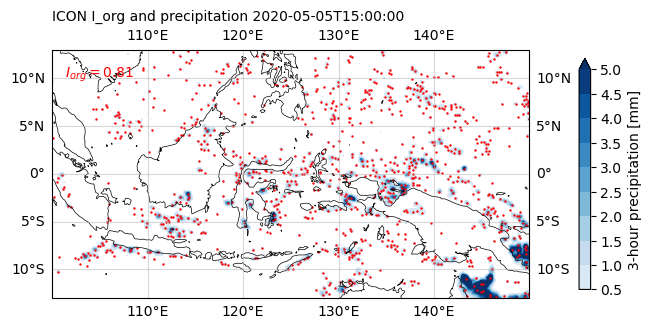

In [5]:
import xarray as xr
import numpy as np
import pandas as pd
from netCDF4 import Dataset 

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy


f_pr_thresh = xr.open_dataset('/g/data/nf33/cb4968/metrics/models/ICON/precip/pr_percentiles/icon_d3hp003/pr_percentiles_icon_d3hp003_3hrly_0-360_-30-30_3600x1800_2020-03_2021-02.nc')
threshold = np.mean(f_pr_thresh['pr_percentiles_95'])
print('threshold',threshold)
f_pr_thresh.close()


f_iorg = xr.open_dataset('/g/data/nf33/cb4968/metrics/models/ICON/doc_metrics/i_org/icon_d3hp003/i_org_icon_d3hp003_3hrly_100-149_-13-13_3600x1800_2020-03_2021-02.nc')
i_org_95 = f_iorg['i_org_thres_pr_percentiles_95']
f_iorg.close()

file_pr = '/g/data/w28/ym7079/Hackthon/DOC/hk25-AusNode-DOCmeso/get_metrics/Yinglin/icon_pr_2020-05-05.nc'
f_pr = xr.open_dataset(file_pr)
pr_95 = f_pr['pr']
f_pr.close()

''' 
# -----------------
#     I_org
# -----------------
paper: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016ms000802

'''

# == imports ==
# -- packages --
import numpy as np
import xarray as xr
from scipy.ndimage import convolve
from scipy.ndimage import maximum_filter


# == smoothing function --
def exponential_kernel(size, decay_distance):
    ''' Creates grid to smooth over, and the magnitude of decay '''
    x, y = np.meshgrid(np.arange(size), np.arange(size))        # matrix to smooth over
    dist = np.sqrt((x - size//2)**2 + (y - size//2)**2)         # distance to smooth over
    kernel = np.exp(-dist / decay_distance)                     # rate of decay
    kernel /= kernel.sum()                                      # smoothing
    return kernel

def apply_smoothing(da_orig, kernel_size, decay_distance):
    kernel = exponential_kernel(size = kernel_size, decay_distance = decay_distance)
    da = convolve(da_orig, kernel, mode='nearest')                   # returns numpy, so put in xarray again later
    da = xr.DataArray(                                          
        data = da,
        dims=["lat", "lon"],
        coords={"lat": da_orig.lat, "lon": da_orig.lon},
        )
    return da

def find_conv_cores(da, threshold, exceed_threshold = True):
    # -- find local maxima --
    local_max = maximum_filter(da, size=3)
    local_maxima = (da == local_max) * 1

    # -- only consider points above threshold --
    if exceed_threshold:
        local_maxima = (local_maxima * da) > threshold

    # -- find associated lat, lon --
    latitudes, longitudes = np.where(local_maxima)
    lat_values = local_maxima.lat.values[latitudes]
    lon_values = local_maxima.lon.values[longitudes]
    return da, lat_values, lon_values


def get_area_matrix(lat, lon):
    ''' # area of domain: cos(lat) * (dlon * dlat) R^2 (area of gridbox decrease towards the pole as gridlines converge) '''
    lonm, latm = np.meshgrid(lon, lat)
    dlat = lat.diff(dim='lat').data[0]
    dlon = lon.diff(dim='lon').data[0]
    R = 6371     # km
    area =  np.cos(np.deg2rad(latm))*np.float64(dlon * dlat * R**2*(np.pi/180)**2) 
    da_area = xr.DataArray(data = area, dims = ["lat", "lon"], coords = {"lat": lat, "lon": lon}, name = "area")
    return da_area

# == helper funcs ==
def haversine_dist(lat1, lon1, lat2, lon2):
    '''Great circle distance (from Haversine formula)
    input: 
    lon range: [-180, 180]
    lat range: [-90, 90]
    (Takes vectorized input) 

    Formula:
    h = sin^2(phi_1 - phi_2) + (cos(phi_1)cos(phi_2))sin^2(lambda_1 - lambda_2)
    (1) h = sin(theta/2)^2
    (2) theta = d_{great circle} / R    (central angle, theta)
    (1) in (2) and rearrange for d gives
    d = R * sin^-1(sqrt(h))*2 
    where 
    phi -latitutde
    lambda - longitude
    '''
    R = 6371                                                                                    # radius of earth in km
    lat1 = np.deg2rad(lat1)                                                                     # function requires degrees in radians 
    lon1 = np.deg2rad(lon1-180)                                                                 # and lon in range [-180, 180]
    lat2 = np.deg2rad(lat2)                                                                     #
    lon2 = np.deg2rad(lon2-180)                                                                 #
    h = np.sin((lat2 - lat1)/2)**2 + np.cos(lat1)*np.cos(lat2) * np.sin((lon2 - lon1)/2)**2     # Haversine formula
    h = np.clip(h, 0, 1)                                                                        # float point precision sometimes give error
    result =  2 * R * np.arcsin(np.sqrt(h))                                                     # formula rearranged for spherical distance
    return result


# == convective-core evaluation funcs ==
def get_cdf(lat_coords, lon_coords):
    n = len(lat_coords)                                                                         # number of convective points
    # -- find nearest neighbour distance between convective cores --
    NN_distances = []
    for a in np.arange(0, n):
        conv_a_lat = np.array([lat_coords[a]] * n)
        conv_a_lon = np.array([lon_coords[a]] * n)
        pair_distances = haversine_dist(conv_a_lat, conv_a_lon, lat_coords, lon_coords)         # distance to other convective points
        NN_distances.append(np.min(pair_distances[pair_distances > 0]))                         # distance to closest other convective gridbox
    NN_distances = np.array(NN_distances)                                                       # minimum distance of touching points is about 270 km
    # -- cdf of "observed" distribution --
    r = np.linspace(np.min(NN_distances), np.max(NN_distances), 100)                            # Range of distances
    sorted_NN_distances = np.sort(NN_distances)
    cumulative_sum = np.zeros_like(r)
    for i, val in enumerate(r):
        cumulative_sum[i] = np.sum(sorted_NN_distances <= val)
    obs_cdf = cumulative_sum / len(sorted_NN_distances)
    return obs_cdf, n, NN_distances, r

def get_poisson_cdf(da, n, NN_distances, r):
    ''' Expected cdf from random poisson process '''
    # -- cdf of theoretical distribution --
    lamda = n / get_area_matrix(da.lat, da.lon).sum().data                                     # normalization factor
    poisson_cdf = 1 - np.exp(-lamda * np.pi * (r - np.min(NN_distances))**2)                    # cdf of random distribution
    return poisson_cdf

# == metric calc ==
def get_i_org(da, lat_coords, lon_coords):
    obs_cdf, n, NN_distances, r = get_cdf(lat_coords, lon_coords)
    poisson_cdf = get_poisson_cdf(da, n, NN_distances, r)
    # i_org = simps(obs_cdf, poisson_cdf)
    i_org = np.trapz(obs_cdf, poisson_cdf)
    return i_org

# == when this script is ran ==
if __name__ == '__main__':

    # -- data --
    ds = xr.open_dataset(file_pr)  # file pr
    da = ds['pr'].isel(time = 5)
    lon_area = '100:150'
    lat_area = '-13:13'  
    da = da.sel(lon = slice(int(lon_area.split(':')[0]), int(lon_area.split(':')[1])), 
                lat = slice(int(lat_area.split(':')[0]), int(lat_area.split(':')[1]))
                )*3600
    da = da.fillna(0)
    da_orig = da

    # -- "example convective threshold" --
    #threshold = da.quantile(0.95).data

    # -- smoothing --
    kernel_size, decay_distance = 8, 1
    da_smooth = apply_smoothing(da_orig, kernel_size, decay_distance)
    # -- cores --
    da, lat_coords, lon_coords = find_conv_cores(da_smooth, threshold, exceed_threshold = True)

    obs_cdf, n, NN_distances, r = get_cdf(lat_coords, lon_coords)
    
    # -- cdf expected by random distribution --
    poisson_cdf = get_poisson_cdf(da, n, NN_distances, r)

    # -- i_org --
    i_org = np.trapz(obs_cdf,poisson_cdf)
    print(i_org)


data_proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
#ax.set_global()
ax.set_extent([100, 150, -13, 13], crs=ccrs.PlateCarree())
ax.set_title('ICON I_org and precipitation 2020-05-05T15:00:00 ',loc ='left',fontsize=10)
#ax.set_title('Moisture Sources for Precipitation 25 Feb 2022\nprecip [mean:23.13mm,max:223.31mm]\nSplitting_together (considering convection)',fontsize=fsize)
ax.add_feature(cartopy.feature.OCEAN, color='white', zorder=0)
ax.add_feature(cartopy.feature.LAND, color='white',zorder=0, 
               linewidth=0.5, edgecolor='black')    
ax.coastlines(resolution='50m', linewidth=0.5, color='black')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,alpha=0.5)

c = ax.contourf(
da.lon, da.lat,
da, ###chaneg pr_95[2,:,:],
cmap='Blues',
levels=[0.5,1, 1.5, 2,2.5,3,3.5,4,4.5, 5],
vmin=0,
vmax=5,
extend='max',
transform=data_proj)

ax.scatter(lon_coords, lat_coords, color='red', s=0.5, transform=ccrs.PlateCarree(), label='cores')
cbar = plt.colorbar(c,pad=0.08,shrink =0.5)
cbar.set_label('3-hour precipitation [mm]')
ax.text(0.1, 0.9, f"$I_{{org}} = {i_org:.2f}$", transform=ax.transAxes, fontsize=10, ha='center', va='center',color='red')
plt.savefig('/g/data/w28/ym7079/Hackthon/DOC/hk25-AusNode-DOCmeso/get_metrics/Yinglin/icon_i_org_min.png', dpi=300, bbox_inches='tight', transparent=False,format='png')
plt.show()